# ToF jitter calculation

In [1]:
#import sys
#!{sys.executable} -m pip install scikit-optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp2d
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy.optimize as skopt
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

## Read and plot the outcome of the gun simulation from Results file

In [2]:

X_mesh = []
Y_mesh = []
TOF_carrier = []
energy_carrier = []
with open('Results_inverted_0323.txt','r') as f:
    count = 0
    for line in f.readlines():
        if count == 0:
            dimX,dimY = [int(x) for x in line.strip('\n').split(',')]
            count += 1
        else:
            X_Y_ToF_E = [float(x) for x in line.split(' ')]
            X_mesh.append(X_Y_ToF_E[0])
            Y_mesh.append(X_Y_ToF_E[1])
            TOF_carrier.append(X_Y_ToF_E[2])
            energy_carrier.append(X_Y_ToF_E[3])
    f.close()
X_mesh = np.asarray(X_mesh).reshape(dimX,dimY)
Y_mesh = np.asarray(Y_mesh).reshape(dimX,dimY)
TOF_carrier = np.asarray(TOF_carrier).reshape(dimX,dimY)
energy_carrier = np.asarray(energy_carrier).reshape(dimX,dimY)

#TOF_carrier = np.transpose(TOF_carrier)
#energy_carrier = np.transpose(energy_carrier)
total_energy = energy_carrier + 0.511
gamma_carrier = (energy_carrier+0.511)/0.511


Gun_amplitudes = [sub[0] for sub in Y_mesh]
Gun_phases = X_mesh[0]

In [3]:
c = 3e8 #m/s
c_light = 3e8
f = 1.3e9 #Hz
w = 2*np.pi*f #rad/s
w_deg = w*180/np.pi #deg/s

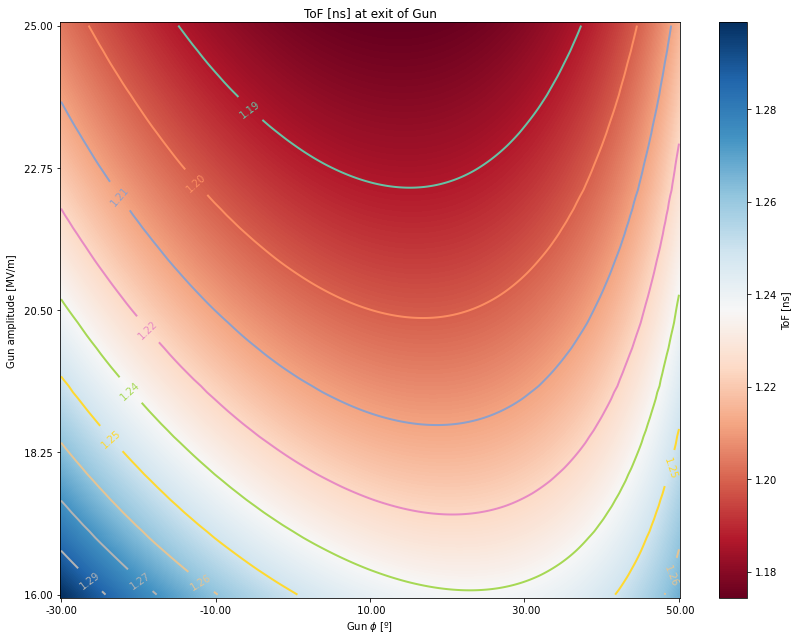

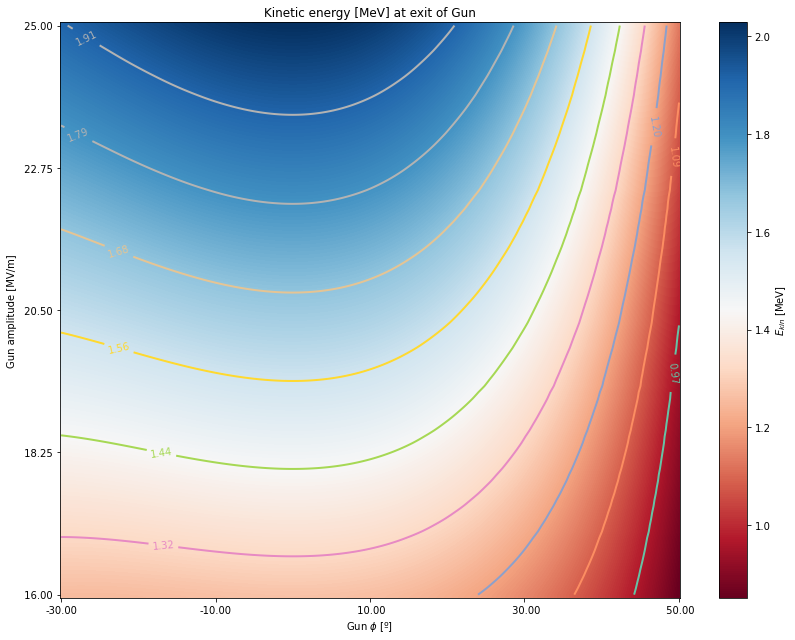

In [4]:
#------------------------------------------PLOT GUN EXIT TIME OF FLIGHT-----------------------------------


fig_TOF,(ax_TOF) = plt.subplots(1,1,figsize=(12,9))
fig_TOF.subplots_adjust(hspace=0,wspace=0)
#c = ax.pcolormesh(z_positions, x_positions, -grid_by, cmap='plasma', vmin=grid_by.min(), vmax=grid_by.max())
ax_TOF.set_title('ToF [ns] at exit of Gun')
ax_TOF.set_ylabel(r'Gun amplitude [MV/m]')
ax_TOF.set_xlabel(r'Gun $\phi$ [º]')

im = imshow(TOF_carrier*1e9,interpolation='spline16',cmap=cm.RdBu,aspect="auto")#extent=[-20.0,50.0,15.0,25.0]) # drawing the function
# Where we want the ticks, in pixel locations
ticks_x = np.linspace(0,90,5)
ticks_y = np.linspace(0,320,5)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here

ticklabels_x= ["{:6.2f}".format(i) for i in (ticks_x/10.0+16.0)]
ticklabels_y= ["{:6.2f}".format(i) for i in (ticks_y/4.0-30.0)]
ax_TOF.set_yticks(ticks_x)
ax_TOF.set_yticklabels(ticklabels_x)
ax_TOF.set_xticks(ticks_y)
ax_TOF.set_xticklabels(ticklabels_y)

# adding the Contour lines with labels
cset = contour(TOF_carrier*1e9,np.arange(np.min(TOF_carrier*1e9),np.max(TOF_carrier*1e9),(np.max(TOF_carrier*1e9)-np.min(TOF_carrier*1e9))/10.0),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
#plt.imshow(TOF_carrier,interpolation='spline16' )
plt.tight_layout()
plt.gca().invert_yaxis()
cbar = fig_TOF.colorbar(im)
cbar.ax.set_ylabel('ToF [ns]')
fig_TOF.savefig('TOF_colormap.png')
plt.show()
plt.close()


#------------------------------------------PLOT GUN EXIT ENERGY-----------------------------------


fig_Energy,(ax_Energy) = plt.subplots(1,1,figsize=(12,9))
fig_Energy.subplots_adjust(hspace=0,wspace=0)
#c = ax.pcolormesh(z_positions, x_positions, -grid_by, cmap='plasma', vmin=grid_by.min(), vmax=grid_by.max())
ax_Energy.set_title('Kinetic energy [MeV] at exit of Gun')
ax_Energy.set_ylabel(r'Gun amplitude [MV/m]')
ax_Energy.set_xlabel(r'Gun $\phi$ [º]')

im = imshow(energy_carrier,interpolation='spline16',cmap=cm.RdBu,aspect="auto")#extent=[-20.0,50.0,15.0,25.0]) # drawing the function
# Where we want the ticks, in pixel locations
ticks_x = np.linspace(0,90,5)
ticks_y = np.linspace(0,320,5)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
ticklabels_x= ["{:6.2f}".format(i) for i in (ticks_x/10.0+16.0)]
ticklabels_y= ["{:6.2f}".format(i) for i in (ticks_y/4.0-30.0)]
ax_Energy.set_yticks(ticks_x)
ax_Energy.set_yticklabels(ticklabels_x)
ax_Energy.set_xticks(ticks_y)
ax_Energy.set_xticklabels(ticklabels_y)

# adding the Contour lines with labels
cset = contour(energy_carrier,np.arange(np.min(energy_carrier),np.max(energy_carrier),(np.max(energy_carrier)-np.min(energy_carrier))/10.0),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
#plt.imshow(TOF_carrier,interpolation='spline16' )
plt.tight_layout()
plt.gca().invert_yaxis()
cbar = fig_Energy.colorbar(im)
cbar.ax.set_ylabel(r'$E_{kin}$ [MeV]')
fig_Energy.savefig('Energy_colormap.png')
plt.show()
plt.close()


# Jitter Calculation at position L

(91, 321)
(91, 321)


/tmp/ipykernel_292061/3934016584.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(['{:.1f}'.format((np.exp(t))) for t in cbar.ax.get_yticks()])


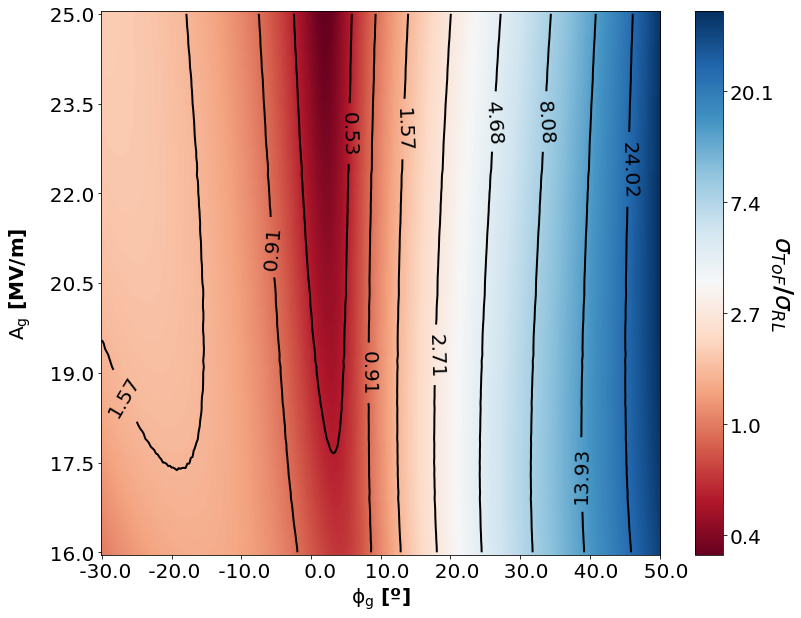

/tmp/ipykernel_292061/3934016584.py:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbarE.set_ticklabels(['{:3d}'.format(int(np.exp(t))) for t in cbarE.ax.get_yticks()])


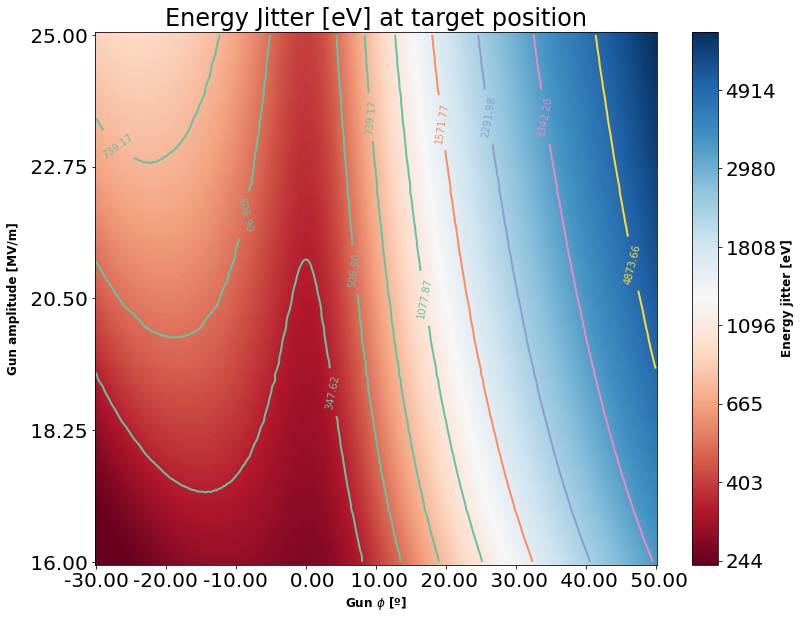

In [5]:
L = 7.64 - 0.323

#Now we have a grid in 2d with the TOF saved in TOF_carrier, evaluated at the points Gun_amplitudes,Gun_phases. We will interpolate it.
TOF_2d = interp2d(Gun_phases,Gun_amplitudes,TOF_carrier,kind='cubic')
Energy_2d = interp2d(Gun_phases,Gun_amplitudes,energy_carrier,kind='cubic') #Kinetic energy
Gamma_2d = interp2d(Gun_phases,Gun_amplitudes,gamma_carrier,kind='cubic')
Total_energy_2d = interp2d(Gun_phases,Gun_amplitudes,total_energy,kind='cubic') #Total energy

Amplitude = 20.0
Phase = 2.234
w = 2*np.pi*1.3e9
sigma_laser = 300e-15
sigma_phase = np.sqrt(0.05**2 + (w*sigma_laser*180/np.pi)**2) #0.15
sigma_amplitude = Amplitude*1e-4

sigma_time = sigma_phase*np.pi/(180.0*w)*1e15 

TOF = []
Jitter_values = []
Energy_jitter = []
Energy_values = []
#Time of flight Jitter at target point (L) for the scanned angles and amplitudes
for j in range(len(Gun_phases)):
    Energy_values.append([])
    Jitter_values.append([])
    Energy_jitter.append([])
    TOF.append([])
    for i in range(len(Gun_amplitudes)):
        gamma_value = Gamma_2d(Gun_phases[j],Gun_amplitudes[i])
        beta_value = np.sqrt(gamma_value**2-1)/gamma_value
        TOF_derivative_phase = TOF_2d(Gun_phases[j],Gun_amplitudes[i],dx=1,dy=0)
        TOF_derivative_amplitude = TOF_2d(Gun_phases[j],Gun_amplitudes[i],dx=0,dy=1)
        gamma_derivative_phase = Gamma_2d(Gun_phases[j],Gun_amplitudes[i],dx=1,dy=0)
        gamma_derivative_amplitude = Gamma_2d(Gun_phases[j],Gun_amplitudes[i],dx=0,dy=1)
        sigma_amplitude = Gun_amplitudes[i]*1e-4
        Jitter_value = np.sqrt((TOF_derivative_phase - L*gamma_derivative_phase/(c_light*(gamma_value**2-1)**(3.0/2.0)))**2*sigma_phase**2+(TOF_derivative_amplitude-L*gamma_derivative_amplitude/(c_light*(gamma_value**2-1)**(3.0/2.0)))**2*sigma_amplitude**2)[0]
        Energy_jitter_value = np.sqrt((gamma_derivative_phase*0.511*sigma_phase)**2+(gamma_derivative_amplitude*sigma_amplitude)**2)[0]
        Jitter_values[j].append(Jitter_value*1e15) #fs
        Energy_jitter[j].append(Energy_jitter_value*1e6) #eV
        Energy_values.append(gamma_value*0.511)    #MeV
Jitter_values = np.transpose(np.asarray(Jitter_values))
Energy_jitter = np.transpose(np.asarray(Energy_jitter))

print(Jitter_values.shape)
print(Energy_jitter.shape)


#------------------------------------------PLOT TOF JITTER AT TARGET POSITION (DEFINED BY L)-----------------------------------
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.weight'] = 12
plt.rcParams['font.size'] = 20

fig_jitter,(ax_jitter) = plt.subplots(1,1,figsize=(12,9))
fig_jitter.subplots_adjust(hspace=0,wspace=0)
#c = ax.pcolormesh(z_positions, x_positions, -grid_by, cmap='plasma', vmin=grid_by.min(), vmax=grid_by.max())
#ax_jitter.set_title('TOF Jitter [fs] at target position')
ax_jitter.set_ylabel(r'$\mathrm{A_g}$ [MV/m]',fontsize=20)
ax_jitter.set_xlabel(r'$\mathrm{\phi_g}$ [º]',fontsize=20)

im = imshow(np.log(Jitter_values/sigma_time),interpolation='spline16',cmap=cm.RdBu, aspect="auto")#,extent=[-20.0,50.0,15.0,25.0]) # drawing the function
# Where we want the ticks, in pixel locations

ticks_x = np.linspace(0,320,9)
ticks_y = np.linspace(0,90,7)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
ticklabels_y= ["{:6.1f}".format(i) for i in (ticks_y/10.0+16.0)]
ticklabels_x= ["{:6.1f}".format(i) for i in (ticks_x/4.0-30.0)]
ax_jitter.set_xticks(ticks_x)
ax_jitter.set_xticklabels(ticklabels_x,fontsize=20)
ax_jitter.set_yticks(ticks_y)
ax_jitter.set_yticklabels(ticklabels_y,fontsize=20)

# adding the Contour lines with labels
#cset = contour(np.log(Jitter_values),np.arange(np.min(np.log(Jitter_values)),np.max(np.log(Jitter_values)),(np.max(np.log(Jitter_values))-np.min(np.log(Jitter_values)))/10.0),linewidths=2,cmap=cm.Set2)
cset = contour(Jitter_values/sigma_time,np.logspace(np.min(np.log(Jitter_values/sigma_time)),np.max(np.log(Jitter_values/sigma_time)),num=10, base = np.exp(1.0)),linewidths=2,colors='black')#cmap=plt.get_cmap('gray'))
clabel(cset,inline=True,fmt='%1.2f',fontsize=20)
#plt.imshow(TOF_carrier,interpolation='spline16' )
plt.tight_layout()
plt.gca().invert_yaxis()


#cbar = plt.colorbar(extend='both')
cbar = fig_jitter.colorbar(im)
#cbar.ax.set_ylabel(r'$\sigma_{ToF}$/$\sigma_{RL}$', fontsize = 22, rotation=270)
cbar.set_label(r'$\sigma_{ToF}$/$\sigma_{RL}$', fontsize = 25,rotation=270,labelpad=20)

#cbar.set_ticks([t for t in cbar.ax.get_yticks()])
cbar.set_ticklabels(['{:.1f}'.format((np.exp(t))) for t in cbar.ax.get_yticks()])
#cbar.set_clim(97.0, 13277.2)
fig_jitter.savefig('Jitter_colormap.png',dpi=600)
plt.show()
plt.close()
                                
                                
                                
#------------------------------------------PLOT ENERGY JITTER AT TARGET POSITION (DEFINED BY L)-----------------------------------
fig_Ejitter,(ax_Ejitter) = plt.subplots(1,1,figsize=(12,9))
fig_Ejitter.subplots_adjust(hspace=0,wspace=0)
#c = ax.pcolormesh(z_positions, x_positions, -grid_by, cmap='plasma', vmin=grid_by.min(), vmax=grid_by.max())
ax_Ejitter.set_title('Energy Jitter [eV] at target position')
ax_Ejitter.set_ylabel(r'Gun amplitude [MV/m]')
ax_Ejitter.set_xlabel(r'Gun $\phi$ [º]')

imE = imshow(np.log(Energy_jitter),interpolation='spline16',cmap=cm.RdBu,aspect="auto")#extent=[-20.0,50.0,15.0,25.0]) # drawing the function
# Where we want the ticks, in pixel locations

ticks_x = np.linspace(0,320,9)
ticks_y = np.linspace(0,90,5)
# What those pixel locations correspond to in data coordinates.
# Also set the float format here
ticklabels_y= ["{:6.2f}".format(i) for i in (ticks_y/10.0+16.0)]
ticklabels_x= ["{:6.2f}".format(i) for i in (ticks_x/4.0-30.0)]
ax_Ejitter.set_xticks(ticks_x)
ax_Ejitter.set_xticklabels(ticklabels_x)
ax_Ejitter.set_yticks(ticks_y)
ax_Ejitter.set_yticklabels(ticklabels_y)

# adding the Contour lines with labels
#cset = contour(np.log(Jitter_values),np.arange(np.min(np.log(Jitter_values)),np.max(np.log(Jitter_values)),(np.max(np.log(Jitter_values))-np.min(np.log(Jitter_values)))/10.0),linewidths=2,cmap=cm.Set2)
cset = contour(Energy_jitter,np.logspace(np.min(np.log(Energy_jitter)),np.max(np.log(Energy_jitter)),num=10, base = np.exp(1.0)),linewidths=2,cmap=cm.Set2)
clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
#plt.imshow(TOF_carrier,interpolation='spline16' )
plt.tight_layout()
plt.gca().invert_yaxis()
cbarE = fig_Ejitter.colorbar(imE)
#cbarE.set_ticks([t for t in cbarE.ax.get_yticks()])
cbarE.set_ticklabels(['{:3d}'.format(int(np.exp(t))) for t in cbarE.ax.get_yticks()])
cbarE.ax.set_ylabel('Energy jitter [eV]')
fig_Ejitter.savefig('Energy_jitter_colormap.png')
plt.show()
plt.close()                                

In [6]:
print(np.amin(Jitter_values))
print(np.argmin(Jitter_values))
TOF_carrier.shape

print(np.amax(Jitter_values))

Jitter_2d = interp2d(Gun_phases, Gun_amplitudes, Jitter_values,kind='cubic')

new_phases = np.linspace(-30.0,50.0,8001)
Jitter_values_20 = Jitter_2d(new_phases,20.0)
Jitter_values_25 = Jitter_2d(new_phases,25.0)
min_phase_index_20 = np.argmin(Jitter_values_20)
min_phase_index_25 = np.argmin(Jitter_values_25)

print(new_phases[min_phase_index_20],new_phases[min_phase_index_25])
print(Jitter_values_20[min_phase_index_20],Jitter_values_25[min_phase_index_25])

97.72310366550589
29018
13192.002710233564
2.5900000000000034 1.9499999999999993
138.3872354058231 97.70928772532166


# Final Method: Gun + Booster

In [ ]:
c_light = 3.0e8
e = 1.6e-19
me_SI = 9.1e-31
me_nat = me_SI*c_light**2 / 1.6e-19
rest_energy = me_SI*c_light**2



frequency = 1.3e9
wavelength = c_light/frequency
w = 2*np.pi*frequency
k = 2*np.pi/wavelength
length_booster = 1.0*wavelength

Amplitude_b1 = 1.23936e6
V0_b1 = e*Amplitude_b1*length_booster/2.0
Amplitude_gun = 20.0 #MV/m
Phase_gun = 2.234 #ToF and energy maps are built with Astra phase for the gun



sigma_RL = 300e-15
sigma_phase_gun = 0.05
sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
print(sigma_phase_gun)
sigma_amplitude_gun = Amplitude_gun*1e-4
sigma_phase_b1 = 0.05*np.pi/180
sigma_amplitude_Vb1 = V0_b1*1e-4

L1 = 3.20 - 0.19
L2 = 12.0 - 3.20

        
t_gun = TOF_2d(Phase_gun,Amplitude_gun)
gamma_gun = Gamma_2d(Phase_gun,Amplitude_gun)
E_gun = Total_energy_2d(Phase_gun,Amplitude_gun)*e*1e6 #in J

#Phase scan to find Maximum energy gain phase for booster1:
phase_scans = np.linspace(0.0,2*np.pi,10000)
maximum = 0.0
index = 0
for k in range(len(phase_scans)):
    E_1 = E_gun + V0_b1*np.cos(phase_scans[k] + w*(t_gun + L1*E_gun/(c_light*np.sqrt(E_gun**2-rest_energy**2)))) #in J
    if E_1>maximum:
        index = k
        maximum = E_1
maximum_energy_gain_phase = phase_scans[index]
print(maximum_energy_gain_phase*180/np.pi)
Phase_b1_0 = maximum_energy_gain_phase - 90*np.pi/180 #rad, phase of booster 1 at t=0.0
E_1 = E_gun + V0_b1*np.cos(Phase_b1_0 + w*(t_gun + L1*E_gun/(c_light*np.sqrt(E_gun**2-rest_energy**2)))) #in J
gamma_1 = E_1/(0.511*1e6*e) 


t1 = L1/(c_light*np.sqrt(1.0-1.0/(gamma_gun**2))) #time of flight needed to cross L1
t2 = L2/(c_light*np.sqrt(1.0-1.0/(gamma_1**2))) #time of flight needed to cross L2
sin_factor = np.sin(Phase_b1_0 + w*(t_gun + t1))
cos_factor = np.cos(Phase_b1_0 + w*(t_gun + t1))
L1_factor = L1/(me_SI*c_light**3*(gamma_gun**2-1)**(3.0/2.0))
L2_factor = L2/(me_SI*c_light**3*(gamma_1**2-1)**(3.0/2.0))

Time_of_flight = t_gun + t1 + t2
print(Time_of_flight)
#print(gamma_gun)
#print(gamma_1)

#Finally, to calculate the time of flight jitter for a given configuration we will use the solution that adds the variation of the time of flight in the gun given by the phase and amplitude fluctuations and the time of flight jitter given at the consequent drift
t_gun_derivative_phase_gun = TOF_2d(Phase_gun,Amplitude_gun,dx=1,dy=0)
t_gun_derivative_amplitude_gun = TOF_2d(Phase_gun,Amplitude_gun,dx=0,dy=1)
Energy_gun_derivative_phase_gun = Total_energy_2d(Phase_gun,Amplitude_gun,dx=1,dy=0)*e*1e6 #From MeV/deg to J/deg
Energy_gun_derivative_amplitude_gun = Total_energy_2d(Phase_gun,Amplitude_gun,dx=0,dy=1)*e*1e6 #From MeV*m/MV to J*m/MV
E_1_derivative_phase_gun = Energy_gun_derivative_phase_gun - V0_b1*\
                          sin_factor*w*(t_gun_derivative_phase_gun-L1_factor*Energy_gun_derivative_phase_gun)
E_1_derivative_amplitude_gun = Energy_gun_derivative_amplitude_gun - V0_b1*\
                      sin_factor*w*(t_gun_derivative_amplitude_gun-L1_factor*Energy_gun_derivative_amplitude_gun)                     
print()

derivative_ToF_Vb1 = - L2_factor*cos_factor
#print(derivative_ToF_Vb1*sigma_amplitude_Vb1)

derivative_ToF_Phaseb1 = L2_factor*V0_b1*sin_factor
#print(derivative_ToF_Phaseb1*sigma_phase_b1)

derivative_ToF_Phasegun = t_gun_derivative_phase_gun - L1_factor*Energy_gun_derivative_phase_gun - \
                      L2_factor*E_1_derivative_phase_gun
#print(derivative_ToF_Phasegun*sigma_phase_gun)

derivative_ToF_Vgun = t_gun_derivative_amplitude_gun - L1/(me_SI*c_light**3*(gamma_gun**2-1)**(3.0/2.0))*Energy_gun_derivative_amplitude_gun - \
                      L2_factor*E_1_derivative_amplitude_gun
#print(derivative_ToF_Vgun*sigma_amplitude_gun)
print()


ToF_jitter = np.sqrt((derivative_ToF_Vb1*sigma_amplitude_Vb1)**2 + (derivative_ToF_Phaseb1*sigma_phase_b1)**2 + \
                     (derivative_ToF_Vgun*sigma_amplitude_gun)**2 + (derivative_ToF_Phasegun*sigma_phase_gun)**2)
energy_deviation = np.sqrt((E_1_derivative_phase_gun*sigma_phase_gun)**2 + (E_1_derivative_amplitude_gun*sigma_amplitude_gun)**2 + \
                          (V0_b1*sin_factor*sigma_phase_b1)**2 + (cos_factor*sigma_amplitude_Vb1)**2)
print(ToF_jitter)
print((energy_deviation/E_1)*100)

## Final method:  Gun and Three Boosters 

In [14]:
##---------- GLOBAL CONSTANTS ------------
c_light = 3.0e8
e = 1.6e-19
me_SI = 9.1e-31
me_nat = me_SI*c_light**2 / 1.6e-19
rest_energy = me_SI*c_light**2


##---------- COMMON PARAMETERS FOR ALL CAVITIES ------------
frequency = 1.3e9
wavelength = c_light/frequency
w = 2*np.pi*frequency
k = 2*np.pi/wavelength
length_booster = 1.0*wavelength


##---------- AMPLITUDES AND PHASES FOR CAVITIES ------------
Amplitude_b1 = 8.91e6#7.87e6#4.972087e6
V0_b1 = e*Amplitude_b1*length_booster/2.0
Amplitude_b2 = 9.88e6#9.87e6#9.88e6#8.790252e6
V0_b2 = e*Amplitude_b2*length_booster/2.0
Amplitude_b3 = 9.90e6#4.38e6#9.90e6#4.38e6#1.404318e6
V0_b3 = e*Amplitude_b3*length_booster/2.0
Amplitude_gun = 20.0#18.615803 #MV/m
Phase_gun = 0.0#4.95#-12.31#4.95 #ToF and energy maps are built with Astra phase for the gun
Phase_b1 = 129.0#-17.66#-17.66#129.0# #Relative to on-crest phase
Phase_b2 = 30.7#-57.01#30.7#-57.01#30.7# #Relative to on-crest phase
Phase_b3 = -110.38#-42.95#-42.95#-110.38# #Relative to on-crest phase


##---------- AMPLITUDE AND PHASE DEVIATIONS ------------
sigma_RL = 300e-15
sigma_phase_gun = 0.05
sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
sigma_amplitude_gun = Amplitude_gun*1.0e-4
sigma_phase_b1 = 0.05*np.pi/180
sigma_amplitude_Vb1 = V0_b1*1.0e-4
sigma_phase_b2 = 0.05*np.pi/180
sigma_amplitude_Vb2 = V0_b2*1.0e-4
sigma_phase_b3 = 0.05*np.pi/180
sigma_amplitude_Vb3 = V0_b3*1.0e-4


##---------- DRIFT LENGTHS ------------
Lgun = 0.323
L1 = 3.20 - Lgun
L2 = 4.02 - (L1+Lgun)
L3 = 4.88 - (L2+L1+Lgun)
L4 = 7.64 - (L3+L2+L1+Lgun)




##---------- TIME TO EXIT THE GUN, ENERGY AT L1 AND T1 ------------
t_gun = TOF_2d(Phase_gun,Amplitude_gun)
gamma_gun = Gamma_2d(Phase_gun,Amplitude_gun)
E_gun = Total_energy_2d(Phase_gun,Amplitude_gun)*e*1e6 #in J
t1 = L1*E_gun/(c_light*np.sqrt(E_gun**2-rest_energy**2)) #time of flight needed to cross L1

dtgun_dphasegun = TOF_2d(Phase_gun,Amplitude_gun,dx=1,dy=0)
dtgun_damplitudegun = TOF_2d(Phase_gun,Amplitude_gun,dx=0,dy=1)
degun_dphasegun = Total_energy_2d(Phase_gun,Amplitude_gun,dx=1,dy=0)*e*1e6 #From MeV/deg to J/deg
degun_damplitudegun = Total_energy_2d(Phase_gun,Amplitude_gun,dx=0,dy=1)*e*1e6 #From MeV*m/MV to J*m/MV

L1_factor = L1/(me_SI*c_light**3*(gamma_gun**2-1)**(3.0/2.0))
dt1_dphasegun = - L1_factor*degun_dphasegun
dt1_damplitudegun = - L1_factor*degun_damplitudegun




##---------- PARAMETERS AT L2 ------------
#Phase scan to find Maximum energy gain phase for booster1:
phase_scans = np.linspace(0.0,2*np.pi,10000)
maximum = 0.0
index = 0
for k in range(len(phase_scans)):
    E_1 = E_gun + V0_b1*np.cos(phase_scans[k] + w*(t_gun + t1)) #in J
    if E_1>maximum:
        index = k
        maximum = E_1
maximum_energy_gain_phase = phase_scans[index]
#print(maximum_energy_gain_phase*180/np.pi)
Phase_b1_0 = maximum_energy_gain_phase + Phase_b1*np.pi/180 #rad, phase of booster 1 at t=0.0

E_1 = E_gun + V0_b1*np.cos(Phase_b1_0 + w*(t_gun + t1)) #in J
gamma_1 = E_1/(0.511*1e6*e) 
t2 = L2/(c_light*np.sqrt(1.0-1.0/(gamma_1**2))) #time of flight needed to cross L2


L2_factor = L2/(me_SI*c_light**3*(gamma_1**2-1)**(3.0/2.0))
dE1_dphasegun = degun_dphasegun - V0_b1*w*np.sin(Phase_b1_0+w*(t_gun+t1))*(dtgun_dphasegun+dt1_dphasegun)
dE1_damplitudegun = degun_damplitudegun - V0_b1*w*np.sin(Phase_b1_0+w*(t_gun+t1))*(dtgun_damplitudegun+dt1_damplitudegun)
dE1_dphaseb1 = - V0_b1*np.sin(Phase_b1_0 + w*(t_gun + t1))
dE1_damplitudeb1 = np.cos(Phase_b1_0 + w*(t_gun + t1))

dt2_dphasegun = - L2_factor*dE1_dphasegun
dt2_damplitudegun = - L2_factor*dE1_damplitudegun
dt2_dphaseb1 = - L2_factor*dE1_dphaseb1
dt2_damplitudeb1 = - L2_factor*dE1_damplitudeb1



##---------- PARAMETERS AT L3 ------------
#Phase scan to find Maximum energy gain phase for booster1:
maximum = 0.0
index = 0
for k in range(len(phase_scans)):
    E_2 = E_1 + V0_b2*np.cos(phase_scans[k] + w*(t_gun + t1 + t2)) #in J
    if E_2 > maximum:
        index = k
        maximum = E_2
maximum_energy_gain_phase = phase_scans[index]
#print(maximum_energy_gain_phase*180/np.pi)
Phase_b2_0 = maximum_energy_gain_phase + Phase_b2*np.pi/180 #rad, phase of booster 1 at t=0.0

E_2 = E_1 + V0_b2*np.cos(Phase_b2_0 + w*(t_gun + t1 + t2)) #in J
gamma_2 = E_2/(0.511*1e6*e) 
t3 = L3/(c_light*np.sqrt(1.0-1.0/(gamma_2**2))) #time of flight needed to cross L3

L3_factor = L3/(me_SI*c_light**3*(gamma_2**2-1)**(3.0/2.0))
dE2_dphasegun = dE1_dphasegun - V0_b2*w*np.sin(Phase_b2_0+w*(t_gun+t1+t2))*(dtgun_dphasegun+dt1_dphasegun+dt2_dphasegun)
dE2_damplitudegun = dE1_damplitudegun - V0_b2*w*np.sin(Phase_b2_0+w*(t_gun + t1 + t2))*(dtgun_damplitudegun+dt1_damplitudegun+dt2_damplitudegun)
dE2_dphaseb1 = dE1_dphaseb1 - V0_b2*w*np.sin(Phase_b2_0 + w*(t_gun + t1 + t2))*dt2_dphaseb1
dE2_damplitudeb1 = dE1_damplitudeb1 - V0_b2*w*np.sin(Phase_b2_0 + w*(t_gun + t1 + t2))*dt2_damplitudeb1
dE2_dphaseb2 = - V0_b2*np.sin(Phase_b2_0 + w*(t_gun + t1 + t2))
dE2_damplitudeb2 = np.cos(Phase_b2_0 + w*(t_gun + t1 + t2))

dt3_dphasegun = - L3_factor*dE2_dphasegun
dt3_damplitudegun = - L3_factor*dE2_damplitudegun
dt3_dphaseb1 = - L3_factor*dE2_dphaseb1
dt3_damplitudeb1 = - L3_factor*dE2_damplitudeb1
dt3_dphaseb2 = - L3_factor*dE2_dphaseb2
dt3_damplitudeb2 = - L3_factor*dE2_damplitudeb2


##---------- PARAMETERS AT L4 ------------
#Phase scan to find Maximum energy gain phase for booster1:
maximum = 0.0
index = 0
for k in range(len(phase_scans)):
    E_3 = E_2 + V0_b3*np.cos(phase_scans[k] + w*(t_gun + t1 + t2 + t3)) #in J
    if E_3 > maximum:
        index = k
        maximum = E_3
maximum_energy_gain_phase = phase_scans[index]
#print(maximum_energy_gain_phase*180/np.pi)
Phase_b3_0 = maximum_energy_gain_phase + Phase_b3*np.pi/180 #rad, phase of booster 1 at t=0.0

E_3 = E_2 + V0_b3*np.cos(Phase_b3_0 + w*(t_gun + t1 + t2 + t3)) #in J
gamma_3 = E_3/(0.511*1e6*e) 
t4 = L4/(c_light*np.sqrt(1.0-1.0/(gamma_3**2))) #time of flight needed to cross L3

L4_factor = L4/(me_SI*c_light**3*(gamma_3**2-1)**(3.0/2.0))
dE3_dphasegun = dE2_dphasegun - V0_b3*w*np.sin(Phase_b3_0+w*(t_gun+t1+t2+t3))*(dtgun_dphasegun+dt1_dphasegun+dt2_dphasegun+dt3_dphasegun)
dE3_damplitudegun = dE2_damplitudegun - V0_b3*w*np.sin(Phase_b3_0+w*(t_gun + t1 + t2+t3))*(dtgun_damplitudegun+dt1_damplitudegun+dt2_damplitudegun+dt3_damplitudegun)
dE3_dphaseb1 = dE2_dphaseb1 - V0_b3*w*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))*(dt2_dphaseb1 + dt3_dphaseb1)
dE3_damplitudeb1 = dE2_damplitudeb1 - V0_b3*w*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))*(dt2_damplitudeb1 + dt3_damplitudeb1)
dE3_dphaseb2 = dE2_dphaseb2 - V0_b3*w*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))*dt3_dphaseb2
dE3_damplitudeb2 = dE2_damplitudeb2 - V0_b3*w*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))*dt3_damplitudeb2
dE3_dphaseb3 = - V0_b3*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))
dE3_damplitudeb3 = np.cos(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))

dt4_dphasegun = - L4_factor*dE3_dphasegun
dt4_damplitudegun = - L4_factor*dE3_damplitudegun
dt4_dphaseb1 = - L4_factor*dE3_dphaseb1
dt4_damplitudeb1 = - L4_factor*dE3_damplitudeb1
dt4_dphaseb2 = - L4_factor*dE3_dphaseb2
dt4_damplitudeb2 = - L4_factor*dE3_damplitudeb2
dt4_dphaseb3 = - L4_factor*dE3_dphaseb3
dt4_damplitudeb3 = - L4_factor*dE3_damplitudeb3



##---------- COLLECT AND CALCULATE ------------
Time_of_flight = t_gun + t1 + t2 + t3 + t4
print(Time_of_flight)


dToF_dphasegun = dtgun_dphasegun + dt1_dphasegun + dt2_dphasegun + dt3_dphasegun + dt4_dphasegun
dToF_damplitudegun = dtgun_damplitudegun + dt1_damplitudegun + dt2_damplitudegun + dt3_damplitudegun + dt4_damplitudegun 
dToF_dphaseb1 = dt2_dphaseb1 + dt3_dphaseb1 + dt4_dphaseb1
dToF_damplitudeb1 = dt2_damplitudeb1 + dt3_damplitudeb1 + dt4_damplitudeb1
dToF_dphaseb2 = dt3_dphaseb2 + dt4_dphaseb2
dToF_damplitudeb2 = dt3_damplitudeb2 + dt4_damplitudeb2
dToF_dphaseb3 = dt4_dphaseb3
dToF_damplitudeb3 = dt4_damplitudeb3

ToF_Jitter = np.sqrt((dToF_dphasegun*sigma_phase_gun)**2+(dToF_damplitudegun*sigma_amplitude_gun)**2 + 
                    (dToF_dphaseb1*sigma_phase_b1)**2+(dToF_damplitudeb1*sigma_amplitude_Vb1)**2 + 
                    (dToF_dphaseb2*sigma_phase_b2)**2+(dToF_damplitudeb2*sigma_amplitude_Vb2)**2 +
                    (dToF_dphaseb3*sigma_phase_b3)**2+(dToF_damplitudeb3*sigma_amplitude_Vb3)**2)

Energy_deviation = np.sqrt((dE3_dphasegun*sigma_phase_gun)**2 + (dE3_damplitudegun*sigma_amplitude_gun)**2 + 
                          (dE3_dphaseb1*sigma_phase_b1)**2 + (dE3_damplitudeb1*sigma_amplitude_Vb1)**2 +
                          (dE3_dphaseb2*sigma_phase_b2)**2 + (dE3_damplitudeb2*sigma_amplitude_Vb2)**2 +
                          (dE3_dphaseb3*sigma_phase_b3)**2 + (dE3_damplitudeb3*sigma_amplitude_Vb3)**2)

print(np.sqrt((dToF_dphaseb3*sigma_phase_b3)**2+(dToF_damplitudeb3*sigma_amplitude_Vb3)**2))
print(ToF_Jitter)
print((Energy_deviation/E_3)*100)
print(E_3)
#beta3 = np.sqrt(1-1.0/gamma_3**2)
#rel_momentum_deviation = beta3**2*(Energy_deviation/E_3)*100
#print(rel_momentum_deviation)

[2.64322566e-08]
[2.83619827e-13]
[3.08229228e-13]
[0.1035364]
[3.29105847e-13]


# Correlation between ToF and E

In [ ]:
def energy3(phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3):
    frequency = 1.3e9
    wavelength = c_light/frequency
    w = 2*np.pi*frequency
    
    Amplitude_b1 = amplitude_b1
    V0_b1 = e*amplitude_b1*length_booster/2.0
    Amplitude_b2 = amplitude_b2
    V0_b2 = e*amplitude_b2*length_booster/2.0
    Amplitude_b3 = amplitude_b3
    V0_b3 = e*amplitude_b3*length_booster/2.0
    Amplitude_gun = amplitude_gun
    Phase_gun = phase_gun
    Phase_b1_0 = phase_b1 #Booster phases already have to be included after phase scan and in radians!!!!!!!!!!!
    Phase_b2_0 = phase_b2
    Phase_b3_0 = phase_b3
    ##---------- DRIFT LENGTHS ------------
    Lgun = 0.19
    L1 = 3.20 - Lgun
    L2 = 4.02 - (L1+Lgun)
    L3 = 4.88 - (L2+L1+Lgun)
    L4 = 12.0 - (L3+L2+L1+Lgun)
    ##---------- TIME TO EXIT THE GUN, ENERGY AT L1 AND T1 ------------
    t_gun = TOF_2d(Phase_gun,Amplitude_gun)
    gamma_gun = Gamma_2d(Phase_gun,Amplitude_gun)
    E_gun = Total_energy_2d(Phase_gun,Amplitude_gun)*e*1e6 #in J
    t1 = L1*E_gun/(c_light*np.sqrt(E_gun**2-rest_energy**2)) #time of flight needed to cross L1    
    ##---------- PARAMETERS AT L2 ------------
    E_1 = E_gun + V0_b1*np.cos(Phase_b1_0 + w*(t_gun + t1)) #in J
    gamma_1 = E_1/(0.511*1e6*e) 
    t2 = L2/(c_light*np.sqrt(1.0-1.0/(gamma_1**2))) #time of flight needed to cross L2
    ##---------- PARAMETERS AT L3 ------------
    E_2 = E_1 + V0_b2*np.cos(Phase_b2_0 + w*(t_gun + t1 + t2)) #in J
    gamma_2 = E_2/(0.511*1e6*e) 
    t3 = L3/(c_light*np.sqrt(1.0-1.0/(gamma_2**2))) #time of flight needed to cross L3
    ##---------- PARAMETERS AT L4 ------------
    Phase_b3_0 = maximum_energy_gain_phase + Phase_b3*np.pi/180 #rad, phase of booster 1 at t=0.0
    E_3 = E_2 + V0_b3*np.cos(Phase_b3_0 + w*(t_gun + t1 + t2 + t3)) #in J
    return E_3

def time_of_flight(phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3):
    frequency = 1.3e9
    wavelength = c_light/frequency
    w = 2*np.pi*frequency
    
    Amplitude_b1 = amplitude_b1
    V0_b1 = e*amplitude_b1*length_booster/2.0
    Amplitude_b2 = amplitude_b2
    V0_b2 = e*amplitude_b2*length_booster/2.0
    Amplitude_b3 = amplitude_b3
    V0_b3 = e*amplitude_b3*length_booster/2.0
    Amplitude_gun = amplitude_gun
    Phase_gun = phase_gun
    Phase_b1_0 = phase_b1 #Booster phases already have to be included after phase scan and in radians!!!!!!!!!!!
    Phase_b2_0 = phase_b2
    Phase_b3_0 = phase_b3
    ##---------- DRIFT LENGTHS ------------
    Lgun = 0.19
    L1 = 3.20 - Lgun
    L2 = 4.02 - (L1+Lgun)
    L3 = 4.88 - (L2+L1+Lgun)
    L4 = 12.0 - (L3+L2+L1+Lgun)
    ##---------- TIME TO EXIT THE GUN, ENERGY AT L1 AND T1 ------------
    t_gun = TOF_2d(Phase_gun,Amplitude_gun)
    gamma_gun = Gamma_2d(Phase_gun,Amplitude_gun)
    E_gun = Total_energy_2d(Phase_gun,Amplitude_gun)*e*1e6 #in J
    t1 = L1*E_gun/(c_light*np.sqrt(E_gun**2-rest_energy**2)) #time of flight needed to cross L1    
    ##---------- PARAMETERS AT L2 ------------
    E_1 = E_gun + V0_b1*np.cos(Phase_b1_0 + w*(t_gun + t1)) #in J
    gamma_1 = E_1/(0.511*1e6*e) 
    t2 = L2/(c_light*np.sqrt(1.0-1.0/(gamma_1**2))) #time of flight needed to cross L2
    ##---------- PARAMETERS AT L3 ------------
    E_2 = E_1 + V0_b2*np.cos(Phase_b2_0 + w*(t_gun + t1 + t2)) #in J
    gamma_2 = E_2/(0.511*1e6*e) 
    t3 = L3/(c_light*np.sqrt(1.0-1.0/(gamma_2**2))) #time of flight needed to cross L3
    ##---------- PARAMETERS AT L4 ------------
    E_3 = E_2 + V0_b3*np.cos(Phase_b3_0 + w*(t_gun + t1 + t2 + t3)) #in J
    gamma_3 = E_3/(0.511*1e6*e) 
    t4 = L4/(c_light*np.sqrt(1.0-1.0/(gamma_3**2))) #time of flight needed to cross L3
    time_of_flight = t_gun + t1 + t2 + t3 + t4
    return time_of_flight

def PDF(x,mu,sigma): #Definition of Gaussian probability density function (normalized so that the integral = 1)
    #if sigma==0.0:
    #    return 1
    gaussian = np.exp(-(x-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
    return gaussian


def expected_energy3(h,g,f,e,d,c,b,a,phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3):
    frequency = 1.3e9
    wavelength = c_light/frequency
    w = 2*np.pi*frequency
    
    Amplitude_b1 = amplitude_b1
    V0_b1 = e*amplitude_b1*length_booster/2.0
    Amplitude_b2 = amplitude_b2
    V0_b2 = e*amplitude_b2*length_booster/2.0
    Amplitude_b3 = amplitude_b3
    V0_b3 = e*amplitude_b3*length_booster/2.0
    Amplitude_gun = amplitude_gun
    Phase_gun = phase_gun
    Phase_b1 = phase_b1
    Phase_b2 = phase_b2
    Phase_b3 = phase_b3
    sigma_RL = 300e-15
    sigma_phase_gun = 0.05
    sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
    sigma_amplitude_gun = Amplitude_gun*1e-4
    sigma_phase_b1 = 0.05*np.pi/180
    sigma_amplitude_b1 = Amplitude_b1*1e-4
    sigma_phase_b2 = 0.05*np.pi/180
    sigma_amplitude_b2 = Amplitude_b2*1e-4
    sigma_phase_b3 = 0.05*np.pi/180
    sigma_amplitude_b3 = Amplitude_b3*1e-4
    
    # If we are very far away from the PDF when we call the function, we return 0.0
    if ((a>=Phase_gun+sigma_phase_gun*10) or (a<=Phase_gun-sigma_phase_gun*10)):
        return 0.0
    elif ((b>=Amplitude_gun+sigma_amplitude_gun*10) or (b<=Amplitude_gun-sigma_amplitude_gun*10)):
        return 0.0
    elif ((c>=Phase_b1+sigma_phase_b1*10) or (c<=Phase_b1-sigma_phase_b1*10)):
        return 0.0
    elif ((d>=Amplitude_b1+sigma_amplitude_b1*10) or (d<=Amplitude_b1-sigma_amplitude_b1*10)):
        return 0.0  
    elif ((e>=Phase_b2+sigma_phase_b2*10) or (e<=Phase_b2-sigma_phase_b2*10)):
        return 0.0
    elif ((f>=Amplitude_b2+sigma_amplitude_b2*10) or (f<=Amplitude_b2-sigma_amplitude_b2*10)):
        return 0.0 
    elif ((g>=Phase_b3+sigma_phase_b3*10) or (g<=Phase_b3-sigma_phase_b3*10)):
        return 0.0
    elif ((h>=Amplitude_b3+sigma_amplitude_b3*10) or (h<=Amplitude_b3-sigma_amplitude_b3*10)):
        return 0.0  
    
    expected_value_function = energy3(a,b,c,d,e,f,g,h)*(PDF(a,Phase_gun,sigma_phase_gun)*PDF(b,Amplitude_gun,sigma_amplitude_gun)*
                                                PDF(c,Phase_b1,sigma_phase_b1)*PDF(d,Amplitude_b1,sigma_amplitude_b1)*
                                                PDF(e,Phase_b2,sigma_phase_b2)*PDF(f,Amplitude_b2,sigma_amplitude_b2)*
                                                PDF(g,Phase_b3,sigma_phase_b3)*PDF(g,Amplitude_b3,sigma_amplitude_b3))
    return expected_value_function

def expected_energy3_squared(h,g,f,e,d,c,b,a,phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3):
    frequency = 1.3e9
    wavelength = c_light/frequency
    w = 2*np.pi*frequency
    
    Amplitude_b1 = amplitude_b1
    V0_b1 = e*amplitude_b1*length_booster/2.0
    Amplitude_b2 = amplitude_b2
    V0_b2 = e*amplitude_b2*length_booster/2.0
    Amplitude_b3 = amplitude_b3
    V0_b3 = e*amplitude_b3*length_booster/2.0
    Amplitude_gun = amplitude_gun
    Phase_gun = phase_gun
    Phase_b1 = phase_b1
    Phase_b2 = phase_b2
    Phase_b3 = phase_b3
    sigma_RL = 300e-15
    sigma_phase_gun = 0.05
    sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
    sigma_amplitude_gun = Amplitude_gun*1e-4
    sigma_phase_b1 = 0.05*np.pi/180
    sigma_amplitude_b1 = Amplitude_b1*1e-4
    sigma_phase_b2 = 0.05*np.pi/180
    sigma_amplitude_b2 = Amplitude_b2*1e-4
    sigma_phase_b3 = 0.05*np.pi/180
    sigma_amplitude_b3 = Amplitude_b3*1e-4
    
    # If we are very far away from the PDF when we call the function, we return 0.0    
    if ((a>=Phase_gun+sigma_phase_gun*10) or (a<=Phase_gun-sigma_phase_gun*10)):
        return 0.0
    elif ((b>=Amplitude_gun+sigma_amplitude_gun*10) or (b<=Amplitude_gun-sigma_amplitude_gun*10)):
        return 0.0
    elif ((c>=Phase_b1+sigma_phase_b1*10) or (c<=Phase_b1-sigma_phase_b1*10)):
        return 0.0
    elif ((d>=Amplitude_b1+sigma_amplitude_b1*10) or (d<=Amplitude_b1-sigma_amplitude_b1*10)):
        return 0.0  
    elif ((e>=Phase_b2+sigma_phase_b2*10) or (e<=Phase_b2-sigma_phase_b2*10)):
        return 0.0
    elif ((f>=Amplitude_b2+sigma_amplitude_b2*10) or (f<=Amplitude_b2-sigma_amplitude_b2*10)):
        return 0.0 
    elif ((g>=Phase_b3+sigma_phase_b3*10) or (g<=Phase_b3-sigma_phase_b3*10)):
        return 0.0
    elif ((h>=Amplitude_b3+sigma_amplitude_b3*10) or (h<=Amplitude_b3-sigma_amplitude_b3*10)):
        return 0.0  
    expected_value_function = energy3(a,b,c,d,e,f,g,h)*energy3(a,b,c,d,e,f,g,h)*(PDF(a,Phase_gun,sigma_phase_gun)*PDF(b,Amplitude_gun,sigma_amplitude_gun)*
                                                PDF(c,Phase_b1,sigma_phase_b1)*PDF(d,Amplitude_b1,sigma_amplitude_b1)*
                                                PDF(e,Phase_b2,sigma_phase_b2)*PDF(f,Amplitude_b2,sigma_amplitude_b2)*
                                                PDF(g,Phase_b3,sigma_phase_b3)*PDF(g,Amplitude_b3,sigma_amplitude_b3))
    return expected_value_function

def expected_time_of_flight(h,g,f,e,d,c,b,a,phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3):
    frequency = 1.3e9
    wavelength = c_light/frequency
    w = 2*np.pi*frequency
    
    Amplitude_b1 = amplitude_b1
    V0_b1 = e*amplitude_b1*length_booster/2.0
    Amplitude_b2 = amplitude_b2
    V0_b2 = e*amplitude_b2*length_booster/2.0
    Amplitude_b3 = amplitude_b3
    V0_b3 = e*amplitude_b3*length_booster/2.0
    Amplitude_gun = amplitude_gun
    Phase_gun = phase_gun
    Phase_b1 = phase_b1
    Phase_b2 = phase_b2
    Phase_b3 = phase_b3
    sigma_RL = 300e-15
    sigma_phase_gun = 0.05
    sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
    sigma_amplitude_gun = Amplitude_gun*1e-4
    sigma_phase_b1 = 0.05*np.pi/180
    sigma_amplitude_b1 = Amplitude_b1*1e-4
    sigma_phase_b2 = 0.05*np.pi/180
    sigma_amplitude_b2 = Amplitude_b2*1e-4
    sigma_phase_b3 = 0.05*np.pi/180
    sigma_amplitude_b3 = Amplitude_b3*1e-4
    
    # If we are very far away from the PDF when we call the function, we return 0.0    
    if ((a>=Phase_gun+sigma_phase_gun*10) or (a<=Phase_gun-sigma_phase_gun*10)):
        return 0.0
    elif ((b>=Amplitude_gun+sigma_amplitude_gun*10) or (b<=Amplitude_gun-sigma_amplitude_gun*10)):
        return 0.0
    elif ((c>=Phase_b1+sigma_phase_b1*10) or (c<=Phase_b1-sigma_phase_b1*10)):
        return 0.0
    elif ((d>=Amplitude_b1+sigma_amplitude_b1*10) or (d<=Amplitude_b1-sigma_amplitude_b1*10)):
        return 0.0  
    elif ((e>=Phase_b2+sigma_phase_b2*10) or (e<=Phase_b2-sigma_phase_b2*10)):
        return 0.0
    elif ((f>=Amplitude_b2+sigma_amplitude_b2*10) or (f<=Amplitude_b2-sigma_amplitude_b2*10)):
        return 0.0 
    elif ((g>=Phase_b3+sigma_phase_b3*10) or (g<=Phase_b3-sigma_phase_b3*10)):
        return 0.0
    elif ((h>=Amplitude_b3+sigma_amplitude_b3*10) or (h<=Amplitude_b3-sigma_amplitude_b3*10)):
        return 0.0  
    expected_value_function = time_of_flight(a,b,c,d,e,f,g,h)*(PDF(a,Phase_gun,sigma_phase_gun)*PDF(b,Amplitude_gun,sigma_amplitude_gun)*
                                                PDF(c,Phase_b1,sigma_phase_b1)*PDF(d,Amplitude_b1,sigma_amplitude_b1)*
                                                PDF(e,Phase_b2,sigma_phase_b2)*PDF(f,Amplitude_b2,sigma_amplitude_b2)*
                                                PDF(g,Phase_b3,sigma_phase_b3)*PDF(h,Amplitude_b3,sigma_amplitude_b3))
    return expected_value_function

def expected_time_of_flight_squared(h,g,f,e,d,c,b,a,phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3):
    frequency = 1.3e9
    wavelength = c_light/frequency
    w = 2*np.pi*frequency
    
    Amplitude_b1 = amplitude_b1
    V0_b1 = e*amplitude_b1*length_booster/2.0
    Amplitude_b2 = amplitude_b2
    V0_b2 = e*amplitude_b2*length_booster/2.0
    Amplitude_b3 = amplitude_b3
    V0_b3 = e*amplitude_b3*length_booster/2.0
    Amplitude_gun = amplitude_gun
    Phase_gun = phase_gun
    Phase_b1 = phase_b1
    Phase_b2 = phase_b2
    Phase_b3 = phase_b3
    sigma_RL = 300e-15
    sigma_phase_gun = 0.05
    sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
    sigma_amplitude_gun = Amplitude_gun*1e-4
    sigma_phase_b1 = 0.05*np.pi/180
    sigma_amplitude_b1 = Amplitude_b1*1e-4
    sigma_phase_b2 = 0.05*np.pi/180
    sigma_amplitude_b2 = Amplitude_b2*1e-4
    sigma_phase_b3 = 0.05*np.pi/180
    sigma_amplitude_b3 = Amplitude_b3*1e-4
    
    # If we are very far away from the PDF when we call the function, we return 0.0   
    if ((a>=Phase_gun+sigma_phase_gun*10) or (a<=Phase_gun-sigma_phase_gun*10)):
        return 0.0
    elif ((b>=Amplitude_gun+sigma_amplitude_gun*10) or (b<=Amplitude_gun-sigma_amplitude_gun*10)):
        return 0.0
    elif ((c>=Phase_b1+sigma_phase_b1*10) or (c<=Phase_b1-sigma_phase_b1*10)):
        return 0.0
    elif ((d>=Amplitude_b1+sigma_amplitude_b1*10) or (d<=Amplitude_b1-sigma_amplitude_b1*10)):
        return 0.0  
    elif ((e>=Phase_b2+sigma_phase_b2*10) or (e<=Phase_b2-sigma_phase_b2*10)):
        return 0.0
    elif ((f>=Amplitude_b2+sigma_amplitude_b2*10) or (f<=Amplitude_b2-sigma_amplitude_b2*10)):
        return 0.0 
    elif ((g>=Phase_b3+sigma_phase_b3*10) or (g<=Phase_b3-sigma_phase_b3*10)):
        return 0.0
    elif ((h>=Amplitude_b3+sigma_amplitude_b3*10) or (h<=Amplitude_b3-sigma_amplitude_b3*10)):
        return 0.0  
    expected_value_function = time_of_flight(a,b,c,d,e,f,g,h)*time_of_flight(a,b,c,d,e,f,g,h)*(PDF(a,Phase_gun,sigma_phase_gun)*PDF(b,Amplitude_gun,sigma_amplitude_gun)*
                                                PDF(c,Phase_b1,sigma_phase_b1)*PDF(d,Amplitude_b1,sigma_amplitude_b1)*
                                                PDF(e,Phase_b2,sigma_phase_b2)*PDF(f,Amplitude_b2,sigma_amplitude_b2)*
                                                PDF(g,Phase_b3,sigma_phase_b3)*PDF(h,Amplitude_b3,sigma_amplitude_b3))
    return expected_value_function

def expected_combination(h,g,f,e,d,c,b,a,phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3):
    frequency = 1.3e9
    wavelength = c_light/frequency
    w = 2*np.pi*frequency

    # If we are very far away from the PDF when we call the function, we return 0.0
    Amplitude_b1 = amplitude_b1
    V0_b1 = e*amplitude_b1*length_booster/2.0
    Amplitude_b2 = amplitude_b2
    V0_b2 = e*amplitude_b2*length_booster/2.0
    Amplitude_b3 = amplitude_b3
    V0_b3 = e*amplitude_b3*length_booster/2.0
    Amplitude_gun = amplitude_gun
    Phase_gun = phase_gun
    Phase_b1 = phase_b1
    Phase_b2 = phase_b2
    Phase_b3 = phase_b3
    sigma_RL = 300e-15
    sigma_phase_gun = 0.05
    sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
    sigma_amplitude_gun = Amplitude_gun*1e-4
    sigma_phase_b1 = 0.05*np.pi/180
    sigma_amplitude_b1 = Amplitude_b1*1e-4
    sigma_phase_b2 = 0.05*np.pi/180
    sigma_amplitude_b2 = Amplitude_b2*1e-4
    sigma_phase_b3 = 0.05*np.pi/180
    sigma_amplitude_b3 = Amplitude_b3*1e-4
    
    if ((a>=Phase_gun+sigma_phase_gun*10) or (a<=Phase_gun-sigma_phase_gun*10)):
        return 0.0
    elif ((b>=Amplitude_gun+sigma_amplitude_gun*10) or (b<=Amplitude_gun-sigma_amplitude_gun*10)):
        return 0.0
    elif ((c>=Phase_b1+sigma_phase_b1*10) or (c<=Phase_b1-sigma_phase_b1*10)):
        return 0.0
    elif ((d>=Amplitude_b1+sigma_amplitude_b1*10) or (d<=Amplitude_b1-sigma_amplitude_b1*10)):
        return 0.0  
    elif ((e>=Phase_b2+sigma_phase_b2*10) or (e<=Phase_b2-sigma_phase_b2*10)):
        return 0.0
    elif ((f>=Amplitude_b2+sigma_amplitude_b2*10) or (f<=Amplitude_b2-sigma_amplitude_b2*10)):
        return 0.0 
    elif ((g>=Phase_b3+sigma_phase_b3*10) or (g<=Phase_b3-sigma_phase_b3*10)):
        return 0.0
    elif ((h>=Amplitude_b3+sigma_amplitude_b3*10) or (h<=Amplitude_b3-sigma_amplitude_b3*10)):
        return 0.0  
    expected_value_function = time_of_flight(a,b,c,d,e,f,g,h)*energy3(a,b,c,d,e,f,g,h)*(PDF(a,Phase_gun,sigma_phase_gun)*PDF(b,Amplitude_gun,sigma_amplitude_gun)*
                                                PDF(c,Phase_b1,sigma_phase_b1)*PDF(d,Amplitude_b1,sigma_amplitude_b1)*
                                                PDF(e,Phase_b2,sigma_phase_b2)*PDF(f,Amplitude_b2,sigma_amplitude_b2)*
                                                PDF(g,Phase_b3,sigma_phase_b3)*PDF(h,Amplitude_b3,sigma_amplitude_b3))

    return expected_value_function                                                
    
    
    

In [ ]:
from scipy import integrate
import time

#Calculate the integrals of the function defined on the previous cell to obtain the expected values.REMEMBER:
# Phases for boosters have to be included already after phase scan and in radians!!!!!!!!!!!!!!!!!!!!!!!!!!!!
amplitude_b1 = 1.23936e6
amplitude_b2 = 2.0e6
amplitude_b3 = 2.0e6
amplitude_gun = 20.0 #MV/m

phase_gun = 2.234 #deg
phase_b1 = -90.0
phase_b2 = 60.0
phase_b3 = 180.0
    
sigma_RL = 300e-15
sigma_phase_gun = 0.05
sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
sigma_amplitude_gun = Amplitude_gun*1e-4
sigma_phase_b1 = 0.05*np.pi/180
sigma_amplitude_b1 = Amplitude_b1*1e-4
sigma_phase_b2 = 0.05*np.pi/180
sigma_amplitude_b2 = Amplitude_b2*1e-4
sigma_phase_b3 = 0.05*np.pi/180
sigma_amplitude_b3 = Amplitude_b3*1e-4

##---------- CALCULATE INITIAL PHASES ------------
frequency = 1.3e9
wavelength = c_light/frequency
w = 2*np.pi*frequency
Lgun = 0.19
L1 = 3.20 - Lgun
L2 = 4.02 - (L1+Lgun)
L3 = 4.88 - (L2+L1+Lgun)
L4 = 12.0 - (L3+L2+L1+Lgun)
t_gun = TOF_2d(Phase_gun,Amplitude_gun)
gamma_gun = Gamma_2d(Phase_gun,Amplitude_gun)
E_gun = Total_energy_2d(Phase_gun,Amplitude_gun)*e*1e6 #in J
t1 = L1*E_gun/(c_light*np.sqrt(E_gun**2-rest_energy**2)) #time of flight needed to cross L1
phase_scans = np.linspace(0.0,2*np.pi,10000)
maximum = 0.0
index = 0
for k in range(len(phase_scans)):
    E_1 = E_gun + V0_b1*np.cos(phase_scans[k] + w*(t_gun + t1)) #in J
    if E_1>maximum:
        index = k
        maximum = E_1
maximum_energy_gain_phase = phase_scans[index]
Phase_b1_0 = maximum_energy_gain_phase + Phase_b1*np.pi/180 #rad, phase of booster 1 at t=0.0
E_1 = E_gun + V0_b1*np.cos(Phase_b1_0 + w*(t_gun + t1)) #in J
gamma_1 = E_1/(0.511*1e6*e) 
t2 = L2/(c_light*np.sqrt(1.0-1.0/(gamma_1**2))) #time of flight needed to cross L2
maximum = 0.0
index = 0
for k in range(len(phase_scans)):
    E_2 = E_1 + V0_b2*np.cos(phase_scans[k] + w*(t_gun + t1 + t2)) #in J
    if E_2 > maximum:
        index = k
        maximum = E_2
maximum_energy_gain_phase = phase_scans[index]
Phase_b2_0 = maximum_energy_gain_phase + Phase_b2*np.pi/180 #rad, phase of booster 1 at t=0.0
E_2 = E_1 + V0_b2*np.cos(Phase_b2_0 + w*(t_gun + t1 + t2)) #in J
gamma_2 = E_2/(0.511*1e6*e) 
t3 = L3/(c_light*np.sqrt(1.0-1.0/(gamma_2**2))) #time of flight needed to cross L3
maximum = 0.0
index = 0
for k in range(len(phase_scans)):
    E_3 = E_2 + V0_b3*np.cos(phase_scans[k] + w*(t_gun + t1 + t2 + t3)) #in J
    if E_3 > maximum:
        index = k
        maximum = E_3
maximum_energy_gain_phase = phase_scans[index]
Phase_b3_0 = maximum_energy_gain_phase + Phase_b3*np.pi/180 #rad, phase of booster 1 at t=0.0

start = time.time()
print('Enter: 1')
ToF_expected_value = integrate.nquad(expected_time_of_flight,
                                     ranges=[(amplitude_b3 - 10*sigma_amplitude_b3,amplitude_b3 + 10*sigma_amplitude_b3),(Phase_b3_0-10*sigma_phase_b3,Phase_b3_0+10*sigma_phase_b3),(amplitude_b2 - 10*sigma_amplitude_b2,amplitude_b2 + 10*sigma_amplitude_b2),(Phase_b2_0-10*sigma_phase_b2,Phase_b2_0+10*sigma_phase_b2),(amplitude_b1 - 10*sigma_amplitude_b1,amplitude_b1 + 10*sigma_amplitude_b1),(Phase_b1_0-10*sigma_phase_b1,Phase_b1_0+10*sigma_phase_b1),(amplitude_gun - 10*sigma_amplitude_gun,amplitude_gun + 10*sigma_amplitude_gun),(phase_gun-10*sigma_phase_gun,phase_gun+10*sigma_phase_gun)],
                                     args=(phase_gun,amplitude_gun,Phase_b1_0,amplitude_b1,Phase_b2_0,amplitude_b2,Phase_b3_0,amplitude_b3),
                                     opts=[{'limit':10},{'limit':10},{'limit':10},{'limit':10},{'limit':10},{'limit':10},{'limit':10},{'limit':10}])#{'points':[0.0]},{},{'points':[0.0]},{},{'points':[0.0]},{},{'points':[0.0]}])#weights='cauchy',wvar=0)
end = time.time()
print(end-start)
print('Done: 1')

energy3_expected_value = integrate.nquad(expected_energy3,
                                         ranges=[(amplitude_b3 - 10*sigma_amplitude_b3,amplitude_b3 + 10*sigma_amplitude_b3),(Phase_b3_0-10*sigma_phase_b3,Phase_b3_0+10*sigma_phase_b3),(amplitude_b2 - 10*sigma_amplitude_b2,amplitude_b2 + 10*sigma_amplitude_b2),(Phase_b2_0-10*sigma_phase_b2,Phase_b2_0+10*sigma_phase_b2),(amplitude_b1 - 10*sigma_amplitude_b1,amplitude_b1 + 10*sigma_amplitude_b1),(Phase_b1_0-10*sigma_phase_b1,Phase_b1_0+10*sigma_phase_b1),(amplitude_gun - 10*sigma_amplitude_gun,amplitude_gun + 10*sigma_amplitude_gun),(phase_gun-10*sigma_phase_gun,phase_gun+10*sigma_phase_gun)],
                                         args=(phase_gun,amplitude_gun,Phase_b1_0,amplitude_b1,Phase_b2_0,amplitude_b2,Phase_b3_0,amplitude_b3))#,opts=[{},{'points':[0.0]},{},{'points':[0.0]},{},{'points':[0.0]},{},{'points':[0.0]}])
end = time.time()
print(end-start)
print('Done: 2')

combination_expected_value = integrate.nquad(expected_combination,
                                             ranges=[(amplitude_b3 - 10*sigma_amplitude_b3,amplitude_b3 + 10*sigma_amplitude_b3),(Phase_b3_0-10*sigma_phase_b3,Phase_b3_0+10*sigma_phase_b3),(amplitude_b2 - 10*sigma_amplitude_b2,amplitude_b2 + 10*sigma_amplitude_b2),(Phase_b2_0-10*sigma_phase_b2,Phase_b2_0+10*sigma_phase_b2),(amplitude_b1 - 10*sigma_amplitude_b1,amplitude_b1 + 10*sigma_amplitude_b1),(Phase_b1_0-10*sigma_phase_b1,Phase_b1_0+10*sigma_phase_b1),(amplitude_gun - 10*sigma_amplitude_gun,amplitude_gun + 10*sigma_amplitude_gun),(phase_gun-10*sigma_phase_gun,phase_gun+10*sigma_phase_gun)],
                                             args=(phase_gun,amplitude_gun,Phase_b1_0,amplitude_b1,Phase_b2_0,amplitude_b2,Phase_b3_0,amplitude_b3))#,opts=[{},{'points':[0.0]},{},{'points':[0.0]},{},{'points':[0.0]},{},{'points':[0.0]}])#weights='cauchy',wvar=0)
end = time.time()
print(end-start)
print('Done: 3')


covariance = combination_expected_value - ToF_expected_value*energy_expected_value
print(ToF_expected_value)
print(energy3_expected_value)
print(covariance)

## Optimization of ToF jitter


In [7]:
def Gun_Booster_jitter(Phases_Amplitudes):
    ##---------- GLOBAL CONSTANTS ------------
    c_light = 3.0e8
    e = 1.6e-19
    me_SI = 9.1e-31
    me_nat = me_SI*c_light**2 / 1.6e-19
    rest_energy = me_SI*c_light**2


    ##---------- COMMON PARAMETERS FOR ALL CAVITIES ------------
    frequency = 1.3e9
    wavelength = c_light/frequency
    w = 2*np.pi*frequency
    k = 2*np.pi/wavelength
    length_booster = 1.0*wavelength


    ##---------- AMPLITUDES AND PHASES FOR CAVITIES ------------
    Phase_gun = Phases_Amplitudes[0]#2.234 #ToF and energy maps are built with Astra phase for the gun
    Amplitude_gun = Phases_Amplitudes[1]#20.0 #MV/m
    Phase_b1 = Phases_Amplitudes[2]#-90.0 #Relative to on-crest phase
    Amplitude_b1 = Phases_Amplitudes[3]#1.23936e6
    Phase_b2 = Phases_Amplitudes[4]#30.0 #Relative to on-crest phase
    Amplitude_b2 = Phases_Amplitudes[5]#5.0e6
    Phase_b3 = Phases_Amplitudes[6]#6.0 #Relative to on-crest phase
    Amplitude_b3 = Phases_Amplitudes[7]#10.0e6
    
    V0_b1 = e*Amplitude_b1*length_booster/2.0
    V0_b2 = e*Amplitude_b2*length_booster/2.0
    V0_b3 = e*Amplitude_b3*length_booster/2.0


    ##---------- AMPLITUDE AND PHASE DEVIATIONS ------------
    sigma_RL = 300e-15
    sigma_phase_gun = 0.05
    sigma_phase_gun = 180*np.sqrt((sigma_phase_gun*np.pi/180)**2+(sigma_RL*w)**2)/np.pi
    sigma_amplitude_gun = Amplitude_gun*1e-4
    sigma_phase_b1 = 0.05*np.pi/180
    sigma_amplitude_Vb1 = V0_b1*1e-4
    sigma_phase_b2 = 0.05*np.pi/180
    sigma_amplitude_Vb2 = V0_b2*1e-4
    sigma_phase_b3 = 0.05*np.pi/180
    sigma_amplitude_Vb3 = V0_b3*1e-4


    ##---------- DRIFT LENGTHS ------------
    Lgun = 0.19
    L1 = 3.20 - Lgun
    L2 = 4.02 - (L1+Lgun)
    L3 = 4.88 - (L2+L1+Lgun)
    L4 = 7.64 - (L3+L2+L1+Lgun)




    ##---------- TIME TO EXIT THE GUN, ENERGY AT L1 AND T1 ------------
    t_gun = TOF_2d(Phase_gun,Amplitude_gun)
    gamma_gun = Gamma_2d(Phase_gun,Amplitude_gun)
    E_gun = Total_energy_2d(Phase_gun,Amplitude_gun)*e*1e6 #in J
    t1 = L1*E_gun/(c_light*np.sqrt(E_gun**2-rest_energy**2)) #time of flight needed to cross L1

    dtgun_dphasegun = TOF_2d(Phase_gun,Amplitude_gun,dx=1,dy=0)
    dtgun_damplitudegun = TOF_2d(Phase_gun,Amplitude_gun,dx=0,dy=1)
    degun_dphasegun = Total_energy_2d(Phase_gun,Amplitude_gun,dx=1,dy=0)*e*1e6 #From MeV/deg to J/deg
    degun_damplitudegun = Total_energy_2d(Phase_gun,Amplitude_gun,dx=0,dy=1)*e*1e6 #From MeV*m/MV to J*m/MV

    L1_factor = L1/(me_SI*c_light**3*(gamma_gun**2-1)**(3.0/2.0))
    dt1_dphasegun = - L1_factor*degun_dphasegun
    dt1_damplitudegun = - L1_factor*degun_damplitudegun




    ##---------- PARAMETERS AT L2 ------------
    #Phase scan to find Maximum energy gain phase for booster1:
    phase_scans = np.linspace(0.0,2*np.pi,10000)
    maximum = 0.0
    index = 0
    for k in range(len(phase_scans)):
        E_1 = E_gun + V0_b1*np.cos(phase_scans[k] + w*(t_gun + t1)) #in J
        if E_1>maximum:
            index = k
            maximum = E_1
    maximum_energy_gain_phase = phase_scans[index]
    #print(maximum_energy_gain_phase*180/np.pi)
    Phase_b1_0 = maximum_energy_gain_phase + Phase_b1*np.pi/180 #rad, phase of booster 1 at t=0.0

    E_1 = E_gun + V0_b1*np.cos(Phase_b1_0 + w*(t_gun + t1)) #in J
    if (E_1<=0.511e6*e):
        print('Outside')
        return 1.0e10 #Just return a very big number so that the optimizer discards this automatically
    gamma_1 = E_1/(0.511*1e6*e) 
    
    t2 = L2/(c_light*np.sqrt(1.0-1.0/(gamma_1**2))) #time of flight needed to cross L2


    L2_factor = L2/(me_SI*c_light**3*(gamma_1**2-1)**(3.0/2.0))
    dE1_dphasegun = degun_dphasegun - V0_b1*w*np.sin(Phase_b1_0+w*(t_gun+t1))*(dtgun_dphasegun+dt1_dphasegun)
    dE1_damplitudegun = degun_damplitudegun - V0_b1*w*np.sin(Phase_b1_0+w*(t_gun+t1))*(dtgun_damplitudegun+dt1_damplitudegun)
    dE1_dphaseb1 = - V0_b1*np.sin(Phase_b1_0 + w*(t_gun + t1))
    dE1_damplitudeb1 = np.cos(Phase_b1_0 + w*(t_gun + t1))

    dt2_dphasegun = - L2_factor*dE1_dphasegun
    dt2_damplitudegun = - L2_factor*dE1_damplitudegun
    dt2_dphaseb1 = - L2_factor*dE1_dphaseb1
    dt2_damplitudeb1 = - L2_factor*dE1_damplitudeb1



    ##---------- PARAMETERS AT L3 ------------
    #Phase scan to find Maximum energy gain phase for booster1:
    maximum = 0.0
    index = 0
    for k in range(len(phase_scans)):
        E_2 = E_1 + V0_b2*np.cos(phase_scans[k] + w*(t_gun + t1 + t2)) #in J
        if E_2 > maximum:
            index = k
            maximum = E_2
    maximum_energy_gain_phase = phase_scans[index]
    #print(maximum_energy_gain_phase*180/np.pi)
    Phase_b2_0 = maximum_energy_gain_phase + Phase_b2*np.pi/180 #rad, phase of booster 1 at t=0.0

    E_2 = E_1 + V0_b2*np.cos(Phase_b2_0 + w*(t_gun + t1 + t2)) #in J
    if (E_2<=0.511e6*e):
        print('Outside')
        return 1.0e10 #Just return a very big number so that the optimizer discards this automatically
    gamma_2 = E_2/(0.511*1e6*e) 
    t3 = L3/(c_light*np.sqrt(1.0-1.0/(gamma_2**2))) #time of flight needed to cross L3

    L3_factor = L3/(me_SI*c_light**3*(gamma_2**2-1)**(3.0/2.0))
    dE2_dphasegun = dE1_dphasegun - V0_b2*w*np.sin(Phase_b2_0+w*(t_gun+t1+t2))*(dtgun_dphasegun+dt1_dphasegun+dt2_dphasegun)
    dE2_damplitudegun = dE1_damplitudegun - V0_b2*w*np.sin(Phase_b2_0+w*(t_gun + t1 + t2))*(dtgun_damplitudegun+dt1_damplitudegun+dt2_damplitudegun)
    dE2_dphaseb1 = dE1_dphaseb1 - V0_b2*w*np.sin(Phase_b2_0 + w*(t_gun + t1 + t2))*dt2_dphaseb1
    dE2_damplitudeb1 = dE1_damplitudeb1 - V0_b2*w*np.sin(Phase_b2_0 + w*(t_gun + t1 + t2))*dt2_damplitudeb1
    dE2_dphaseb2 = - V0_b2*np.sin(Phase_b2_0 + w*(t_gun + t1 + t2))
    dE2_damplitudeb2 = np.cos(Phase_b2_0 + w*(t_gun + t1 + t2))

    dt3_dphasegun = - L3_factor*dE2_dphasegun
    dt3_damplitudegun = - L3_factor*dE2_damplitudegun
    dt3_dphaseb1 = - L3_factor*dE2_dphaseb1
    dt3_damplitudeb1 = - L3_factor*dE2_damplitudeb1
    dt3_dphaseb2 = - L3_factor*dE2_dphaseb2
    dt3_damplitudeb2 = - L3_factor*dE2_damplitudeb2


    ##---------- PARAMETERS AT L4 ------------
    #Phase scan to find Maximum energy gain phase for booster1:
    maximum = 0.0
    index = 0
    for k in range(len(phase_scans)):
        E_3 = E_2 + V0_b3*np.cos(phase_scans[k] + w*(t_gun + t1 + t2 + t3)) #in J
        if E_3 > maximum:
            index = k
            maximum = E_3
    maximum_energy_gain_phase = phase_scans[index]
    #print(maximum_energy_gain_phase*180/np.pi)
    Phase_b3_0 = maximum_energy_gain_phase + Phase_b3*np.pi/180 #rad, phase of booster 1 at t=0.0

    E_3 = E_2 + V0_b3*np.cos(Phase_b3_0 + w*(t_gun + t1 + t2 + t3)) #in J
    if (E_3<=0.511e6*e):
        print('Outside')
        return 1.0e10 #Just return a very big number so that the optimizer discards this automatically
    gamma_3 = E_3/(0.511*1e6*e) 
    t4 = L4/(c_light*np.sqrt(1.0-1.0/(gamma_3**2))) #time of flight needed to cross L3

    L4_factor = L4/(me_SI*c_light**3*(gamma_3**2-1)**(3.0/2.0))
    dE3_dphasegun = dE2_dphasegun - V0_b3*w*np.sin(Phase_b3_0+w*(t_gun+t1+t2+t3))*(dtgun_dphasegun+dt1_dphasegun+dt2_dphasegun+dt3_dphasegun)
    dE3_damplitudegun = dE2_damplitudegun - V0_b3*w*np.sin(Phase_b3_0+w*(t_gun + t1 + t2+t3))*(dtgun_damplitudegun+dt1_damplitudegun+dt2_damplitudegun+dt3_damplitudegun)
    dE3_dphaseb1 = dE2_dphaseb1 - V0_b3*w*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))*(dt2_dphaseb1 + dt3_dphaseb1)
    dE3_damplitudeb1 = dE2_damplitudeb1 - V0_b3*w*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))*(dt2_damplitudeb1 + dt3_damplitudeb1)
    dE3_dphaseb2 = dE2_dphaseb2 - V0_b3*w*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))*dt3_dphaseb2
    dE3_damplitudeb2 = dE2_damplitudeb2 - V0_b3*w*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))*dt3_damplitudeb2
    dE3_dphaseb3 = - V0_b3*np.sin(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))
    dE3_damplitudeb3 = np.cos(Phase_b3_0 + w*(t_gun + t1 + t2 + t3))

    dt4_dphasegun = - L4_factor*dE3_dphasegun
    dt4_damplitudegun = - L4_factor*dE3_damplitudegun
    dt4_dphaseb1 = - L4_factor*dE3_dphaseb1
    dt4_damplitudeb1 = - L4_factor*dE3_damplitudeb1
    dt4_dphaseb2 = - L4_factor*dE3_dphaseb2
    dt4_damplitudeb2 = - L4_factor*dE3_damplitudeb2
    dt4_dphaseb3 = - L4_factor*dE3_dphaseb3
    dt4_damplitudeb3 = - L4_factor*dE3_damplitudeb3



    ##---------- COLLECT AND CALCULATE ------------
    Time_of_flight = t_gun + t1 + t2 + t3 + t4
    #print(Time_of_flight)


    dToF_dphasegun = dtgun_dphasegun + dt1_dphasegun + dt2_dphasegun + dt3_dphasegun + dt4_dphasegun
    dToF_damplitudegun = dtgun_damplitudegun + dt1_damplitudegun + dt2_damplitudegun + dt3_damplitudegun + dt4_damplitudegun 
    dToF_dphaseb1 = dt2_dphaseb1 + dt3_dphaseb1 + dt4_dphaseb1
    dToF_damplitudeb1 = dt2_damplitudeb1 + dt3_damplitudeb1 + dt4_damplitudeb1
    dToF_dphaseb2 = dt3_dphaseb2 + dt4_dphaseb2
    dToF_damplitudeb2 = dt3_damplitudeb2 + dt4_damplitudeb2
    dToF_dphaseb3 = dt4_dphaseb3
    dToF_damplitudeb3 = dt4_damplitudeb3

    ToF_Jitter = np.sqrt((dToF_dphasegun*sigma_phase_gun)**2+(dToF_damplitudegun*sigma_amplitude_gun)**2 + 
                        (dToF_dphaseb1*sigma_phase_b1)**2+(dToF_damplitudeb1*sigma_amplitude_Vb1)**2 + 
                        (dToF_dphaseb2*sigma_phase_b2)**2+(dToF_damplitudeb2*sigma_amplitude_Vb2)**2 +
                        (dToF_dphaseb3*sigma_phase_b3)**2+(dToF_damplitudeb3*sigma_amplitude_Vb3)**2)

    Energy_deviation = np.sqrt((dE3_dphasegun*sigma_phase_gun)**2 + (dE3_damplitudegun*sigma_amplitude_gun)**2 + 
                              (dE3_dphaseb1*sigma_phase_b1)**2 + (dE3_damplitudeb1*sigma_amplitude_Vb1)**2 +
                              (dE3_dphaseb2*sigma_phase_b2)**2 + (dE3_damplitudeb2*sigma_amplitude_Vb2)**2 +
                              (dE3_dphaseb3*sigma_phase_b3)**2 + (dE3_damplitudeb3*sigma_amplitude_Vb3)**2)


    #print(ToF_Jitter)
    #print((Energy_deviation/E_3)*100)
    return(ToF_Jitter[0])

gun_phase_bounds = (-15.0,30.0)
gun_amplitude_bounds = (16.0,25.0)
b1_phase_bounds = (-180.0,180.0)
b1_amplitude_bounds = (0.0,10.0e6)
b2_phase_bounds = (-180.0,180.0)
b2_amplitude_bounds = (0.0,10.0e6)
b3_phase_bounds = (-180.0,180.0)
b3_amplitude_bounds = (0.0,10.0e6)

bounds = [gun_phase_bounds,gun_amplitude_bounds,b1_phase_bounds,b1_amplitude_bounds,b2_phase_bounds,b2_amplitude_bounds,b3_phase_bounds,b3_amplitude_bounds]

import scipy
n_times = 100 
CARRIER_MINIMUM = []
CARRIER_POSITION = []


In [8]:
for i in range(n_times):
    
    amplitude_gun = np.random.rand()*(bounds[1][1]-bounds[1][0]) + bounds[1][0] #20.0 #MV/m
    amplitude_b1 = np.random.rand()*(bounds[3][1]-bounds[3][0]) + bounds[3][0] #7.23936e6
    amplitude_b2 = np.random.rand()*(bounds[5][1]-bounds[5][0]) + bounds[5][0] #2.0e6
    amplitude_b3 = np.random.rand()*(bounds[7][1]-bounds[7][0]) + bounds[7][0] #5.0e6


    phase_gun = np.random.rand()*(bounds[0][1]-bounds[0][0]) + bounds[0][0] #-2.234 #deg
    phase_b1 = np.random.rand()*(bounds[2][1]-bounds[2][0]) + bounds[2][0]  #-30.0
    phase_b2 = np.random.rand()*(bounds[4][1]-bounds[4][0]) + bounds[4][0]  #-30.0
    phase_b3 = np.random.rand()*(bounds[6][1]-bounds[6][0]) + bounds[6][0]  #-60.0

#r = gp_minimize(Gun_Booster_jitter, 
#                bounds, 
#                acq_func='gp_hedge',         # expected improvement
#                n_calls=2000,                 # number of iterations
#                x0=[phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3],
#                acq_optimizer='lbfgs',
#                n_initial_points = 1000,       # initial samples are provided
#                initial_point_generator = 'random'
#                )


    r = scipy.optimize.basinhopping(Gun_Booster_jitter,
                                    x0 = [phase_gun,amplitude_gun,phase_b1,amplitude_b1,phase_b2,amplitude_b2,phase_b3,amplitude_b3],
                                    minimizer_kwargs = {'method':'L-BFGS-B','bounds':bounds},
                                    T=2.5,
                                    niter=300)
    
    CARRIER_MINIMUM.append(r.fun)
    CARRIER_POSITION.append(r.x)
    
    print('Location of minimum: '+str(r.x))
    print('Value of minimum: '+str(r.fun))
    print('Finished: ' + str(i))

print(np.min(np.asarray(CARRIER_MINIMUM)))

Location of minimum: [ 2.54729107e+01  2.31324171e+01  8.06435671e+01  2.28509735e+06
 -1.52513000e+02  8.32506914e+06  9.84025611e+00  5.88980942e+06]
Value of minimum: 1.345055128631311e-12
Finished: 0
Location of minimum: [-5.25673336e+00  2.40645264e+01  1.79651547e+02  5.80623621e+06
  8.45329276e+01  6.59392274e+06  1.00714870e+02  4.49541189e+06]
Value of minimum: 2.0756338884110214e-12
Finished: 1
Location of minimum: [ 1.28143011e+01  2.12481208e+01  9.60034152e+01  3.61977649e+06
  1.67259813e+01  8.56860942e+06 -1.11330248e+02  7.19022198e+05]
Value of minimum: 4.776391694708267e-13
Finished: 2
Location of minimum: [1.65104977e+01 2.32768101e+01 1.42590438e+02 3.38661054e+06
 8.10923523e+01 4.71438567e+06 1.75730483e+02 2.80568369e+06]
Value of minimum: 2.3323805585210938e-12
Finished: 3
Location of minimum: [-9.89825077e+00  1.80206637e+01 -1.16117196e+02  1.79542723e+06
 -1.73676342e+01  4.54222380e+06  4.41858833e+01  1.34446738e+06]
Value of minimum: 1.9811867912173056e-

Location of minimum: [-9.77472436e+00  2.32288897e+01  1.03951267e+02  7.85709562e+06
 -5.90973319e+01  4.52542427e+06 -5.63834321e+01  2.69205002e+05]
Value of minimum: 5.558806057893601e-13
Finished: 22
Location of minimum: [ 9.40939997e-01  2.44978549e+01  1.02011276e+00  4.40807671e+06
 -1.36158856e+02  2.86781224e+06 -3.55840869e+01  3.90588002e+06]
Value of minimum: 7.15564146297995e-14
Finished: 23
Location of minimum: [ 2.64953498e+01  1.76791256e+01 -1.76003599e+02  2.63446494e+06
 -1.59238780e+02  4.85049010e+06  1.27186671e+01  9.89782426e+05]
Value of minimum: 7.923132291688973e-13
Finished: 24
Location of minimum: [-7.63672735e+00  2.21904737e+01  1.48987458e+02  4.65657293e+06
 -1.64534221e+02  6.67327119e+06 -7.95430305e+01  6.52743102e+06]
Value of minimum: 4.545323443615181e-12
Finished: 25
Location of minimum: [ 4.85485289e+00  2.13265045e+01 -2.66085583e+01  3.52557574e+06
 -1.24979421e+02  4.68150469e+05  5.06616221e+01  3.83557822e+06]
Value of minimum: 1.101206722

Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside
Outside


Location of minimum: [ 3.85380596e+00  2.48417761e+01 -4.90993950e+01  1.65020043e+06
  9.21952835e+01  1.77432345e+06 -5.36614815e+01  2.85080776e+06]
Value of minimum: 8.804287484672562e-14
Finished: 77
Location of minimum: [ 6.23265029e+00  2.02292592e+01 -3.71196986e+01  7.82997568e+06
 -7.54846586e+01  9.81644891e+05 -5.49540628e+01  4.13613362e+06]
Value of minimum: 7.870004236413687e-14
Finished: 78
Location of minimum: [-7.72044560e+00  2.50000000e+01  8.86247758e+01  8.80517552e+06
  1.46768272e+02  8.10769284e+06 -1.78143720e+02  1.90850763e+06]
Value of minimum: 3.0475489295376556e-12
Finished: 79
Location of minimum: [9.25242736e+00 2.23703446e+01 1.17595996e+02 6.70825231e+06
 3.04701479e+01 2.90664804e+06 6.76862779e+01 9.19369323e+05]
Value of minimum: 7.030710396283904e-13
Finished: 80
Location of minimum: [1.12600430e+01 1.90983390e+01 7.76801548e+01 6.46998625e+06
 1.48877073e+02 9.23161210e+06 6.26435944e+01 9.49028270e+06]
Value of minimum: 7.301664338222869e-12
Fin

In [9]:
#Minimum with free gun amplitude 66.2fs, located at [ 3.61699203e+00,  1.97960397e+01, -3.39084390e+01,  9.19391136e+06, -5.02216386e+01,  7.54975220e+06,  2.95178450e+01,  9.27126470e+06

index = np.argmin(np.asarray(CARRIER_MINIMUM))
CARRIER_POSITION[index]

array([ 3.61699203e+00,  1.97960397e+01, -3.39084390e+01,  9.19391136e+06,
       -5.02216386e+01,  7.54975220e+06,  2.95178450e+01,  9.27126470e+06])